In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os

## Data Pipeline

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
# dataset_location = './Food ingredient recognition.v4i.tfrecord'
# dataset_location = './drive/MyDrive/Food ingredient recognition.v4i.tfrecord' # Google Colab
dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord" # Punya Andi
tfrecord_name = "food-ingredient.tfrecord"
print(os.path.exists(dataset_location))

True


In [21]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
dataset_validation = tf.data.TFRecordDataset(dataset_location + f"/valid/{tfrecord_name}")
dataset_test = tf.data.TFRecordDataset(dataset_location + f"/test/{tfrecord_name}")

In [22]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [23]:
from keras_cv import bounding_box
from keras_cv import visualization

class_ids = [
    "-",
    "almond",
    "apple",
    "avocado",
    "beef",
    "bell pepper",
    "blueberry",
    "bread",
    "broccoli",
    "butter",
    "carrot",
    "cheese",
    "chilli",
    "cookie",
    "corn",
    "cucumber",
    "egg",
    "eggplant",
    "garlic",
    "lemon",
    "milk",
    "mozarella cheese",
    "mushroom",
    "mussel",
    "onion",
    "oyster",
    "parmesan cheese",
    "pasta",
    "pork rib",
    "potato",
    "salmon",
    "scallop",
    "shrimp",
    "strawberry",
    "toast bread",
    "tomato",
    "tuna",
    "yogurt",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = np.array(image)
    inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image = inference_resizing([image])
    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xywh',
        y_pred=bounding_boxes
    )

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

validation_augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        )
    ]
)

2024-06-08 20:21:29.872696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


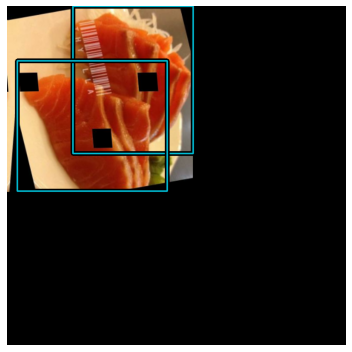

In [24]:
from keras_cv import bounding_box

BATCH_SIZE = 4

train_data_initial = dataset_train.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
train_data_resized = train_data_initial.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

train_data = train_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

for result in train_data.take(1):
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_true=result[1]
    )


In [25]:
validation_data_initial = dataset_validation.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
validation_data_resized = validation_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [26]:
test_data_initial = dataset_test.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
test_data_resized = test_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [27]:
# import keras

# pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
#     "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
# )
# image = keras.utils.load_img("stock-photo-airport-with-many-airplanes-at-beautiful-sunset-324754607.jpg")
# image = np.array(image)
# # print(image.shape)

# visualization.plot_image_gallery(
#     np.array([image]),
#     value_range=(0, 255),
#     rows=1,
#     cols=1,
#     scale=5,)
# inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
# )
# image_batch = inference_resizing([image])
# # print(image_batch)
# class_ids = [
#     "Aeroplane",
#     "Bicycle",
#     "Bird",
#     "Boat",
#     "Bottle",
#     "Bus",
#     "Car",
#     "Cat",
#     "Chair",
#     "Cow",
#     "Dining Table",
#     "Dog",
#     "Horse",
#     "Motorbike",
#     "Person",
#     "Potted Plant",
#     "Sheep",
#     "Sofa",
#     "Train",
#     "Tvmonitor",
#     "Total",
# ]
# # class_mapping = dict(zip(range(len(class_ids)), class_ids))
# # y_pred = pretrained_model.predict(image_batch)

# # print(y_pred)

# for sample in train_data_unbatched.take(1):
#     image = np.array(sample['images'])
#     inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
#     )
#     image = inference_resizing([image])
#     y_pred = pretrained_model.predict(image)
#     print(y_pred)
#     visualization.plot_bounding_box_gallery(
#         image,
#         value_range=(0, 255),
#         rows=1,
#         cols=1,
#         y_pred=y_pred,
#         scale=5,
#         font_scale=0.7,
#         bounding_box_format="xyxy",
#         class_mapping=class_mapping,
#     )


In [28]:
# Get the number of classes in the dataset
# unique_classes = set()
# for parsed_dataset in train_data:
#     classes = parsed_dataset['bounding_boxes']['classes'].numpy()
#     unique_classes.update(np.unique(classes))

# NUM_CLASSES = len(unique_classes)
NUM_CLASSES = len(class_ids)

In [29]:
# Pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    include_rescaling = True,
)

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=True,
    # Makin tinggi perlu confidence makin tinggi
    confidence_threshold=0.731,
    # Makin rendah maka makin sedikit bounding box yang diambil
    iou_threshold=0.2,
    bounding_box_format="xyxy",
)

# model = keras_cv.models.YOLOV8Detector(
#     num_classes=NUM_CLASSES,
#     bounding_box_format="xyxy",
#     backbone=backbone,
#     fpn_depth=1,
#     prediction_decoder=prediction_decoder,
# )


model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_s_backbone_coco", 
    bounding_box_format="xyxy",
    num_classes=NUM_CLASSES,
    prediction_decoder=prediction_decoder,
)



In [30]:
freeze = 133
# Freeze to up to 133 layers
# for i, layer in enumerate(model.layers):
#     if i < freeze:
#         layer.trainable = False


In [31]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [32]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm = 10.0
)

model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    classification_loss=tf.keras.losses.CategoricalCrossentropy(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

model.fit(train_data, 
          epochs=10, 
          validation_data=validation_data,
          callbacks=[EvaluateCOCOMetricsCallback(validation_data, "model.keras")])

Epoch 1/10
    735/Unknown 105s 92ms/step - loss: 1.3744e-04

2024-06-08 20:23:16.760628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:23:16.760674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-06-08 20:23:16.760686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4540596118956551201
2024-06-08 20:23:16.760693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17021272254583444092
2024-06-08 20:23:16.760698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10063152101840848510
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate a

735/735 ━━━━━━━━━━━━━━━━━━━━ 125s 119ms/step - loss: 1.3743e-04 - val_loss: 1.4157e-04 - MaP: 7.2317e-07 - MaP@[IoU=50]: 7.2317e-06 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1730e-06 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 4.7619e-04 - Recall@[max_detections=100]: 4.7619e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.5758e-04
Epoch 2/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.3059e-04

2024-06-08 20:24:45.013993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:24:45.014501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:24:48.097927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:24:48.098171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


735/735 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - loss: 1.3059e-04 - val_loss: 1.3067e-04 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 3/10


2024-06-08 20:24:55.493995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.2604e-04

2024-06-08 20:26:06.471638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:26:06.472153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:26:09.611123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:26:09.611252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:26:17.094855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - loss: 1.2604e-04 - val_loss: 1.3423e-04 - MaP: 2.4929e-05 - MaP@[IoU=50]: 1.7532e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.0872e-05 - Recall@[max_detections=1]: 6.8966e-04 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 4/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.3058e-04

2024-06-08 20:27:28.807143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:27:28.807675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:27:31.847790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:27:31.848103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:27:39.733933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - loss: 1.3058e-04 - val_loss: 1.2951e-04 - MaP: 5.0226e-05 - MaP@[IoU=50]: 1.4088e-04 - MaP@[IoU=75]: 1.3484e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.5249e-05 - Recall@[max_detections=1]: 2.8409e-04 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 5/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.2462e-04

2024-06-08 20:28:50.316202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:28:50.316681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:28:53.473876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:28:53.474169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:29:01.282694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - loss: 1.2462e-04 - val_loss: 1.2461e-04 - MaP: 9.5555e-05 - MaP@[IoU=50]: 7.7268e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0511e-04 - Recall@[max_detections=1]: 0.0016 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0022
Epoch 6/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.2273e-04

2024-06-08 20:30:12.910711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:30:12.910899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:30:15.931264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:30:15.931618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:30:23.186717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 82s 111ms/step - loss: 1.2273e-04 - val_loss: 1.1710e-04 - MaP: 4.5812e-04 - MaP@[IoU=50]: 0.0021 - MaP@[IoU=75]: 2.8289e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.9050e-04 - Recall@[max_detections=1]: 0.0042 - Recall@[max_detections=10]: 0.0042 - Recall@[max_detections=100]: 0.0042 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0045
Epoch 7/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.2212e-04

2024-06-08 20:31:35.986943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:31:35.987436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:31:39.202064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:31:39.202390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:31:47.215163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - loss: 1.2212e-04 - val_loss: 1.2753e-04 - MaP: 7.2004e-06 - MaP@[IoU=50]: 7.2004e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.1001e-04 - MaP@[area=large]: 1.0743e-05 - Recall@[max_detections=1]: 6.9396e-05 - Recall@[max_detections=10]: 6.9396e-05 - Recall@[max_detections=100]: 6.9396e-05 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 8.2305e-05 - Recall@[area=large]: 7.2674e-05
Epoch 8/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.2694e-04

2024-06-08 20:32:58.458112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:32:58.458662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:33:01.770902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:33:01.771426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:33:10.084797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - loss: 1.2694e-04 - val_loss: 1.1980e-04 - MaP: 5.4489e-06 - MaP@[IoU=50]: 3.3593e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.5119e-04 - MaP@[area=large]: 7.0309e-06 - Recall@[max_detections=1]: 1.9841e-05 - Recall@[max_detections=10]: 7.7381e-04 - Recall@[max_detections=100]: 8.1349e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 3.7037e-04 - Recall@[area=large]: 0.0012
Epoch 9/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.2121e-04

2024-06-08 20:34:20.653957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:34:20.654195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:34:23.752746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:34:23.752862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:34:31.647107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - loss: 1.2121e-04 - val_loss: 1.3054e-04 - MaP: 4.4305e-05 - MaP@[IoU=50]: 1.7938e-04 - MaP@[IoU=75]: 4.8502e-07 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.7986e-05 - Recall@[max_detections=1]: 5.3571e-04 - Recall@[max_detections=10]: 7.9365e-04 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0017
Epoch 10/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.2087e-04

2024-06-08 20:35:41.192983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:35:41.193480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:35:44.227825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:35:44.228286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 20:35:51.931722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


735/735 ━━━━━━━━━━━━━━━━━━━━ 80s 108ms/step - loss: 1.2087e-04 - val_loss: 1.3006e-04 - MaP: 2.9064e-07 - MaP@[IoU=50]: 9.6879e-07 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.1862e-07 - Recall@[max_detections=1]: 7.0258e-05 - Recall@[max_detections=10]: 7.0258e-05 - Recall@[max_detections=100]: 7.0258e-05 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.2285e-04


In [33]:
model.evaluate(test_data)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.3590e-04


2024-06-08 20:35:54.300150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 20:35:54.300440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


0.00013694418885279447

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
{'boxes': array([[[100.75682  ,  -5.0233383, 332.05856  , 184.70065  ],
        [371.1575   ,  -4.       , 596.       , 172.       ],
        [ 28.45877  ,  99.987495 , 266.73282  , 276.70865  ],
        ...,
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ]],

       [[220.26105  , 195.99954  , 459.99683  , 373.30838  ],
        [ 60.27263  , 203.96223  , 292.2705   , 394.00604  ],
        [254.77972  , 308.       , 492.       , 484.0002   ],
        ...,
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.       ]],

       [[148.00018  , 156.00922  , 371.99994  , 393.84335  ],
        [ -2.2421494, 163.4391   , 128.18156  , 280.83987  ],
        [ -1.       ,  -1.       ,  -1.       ,  -1.  

2024-06-08 20:35:55.287605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


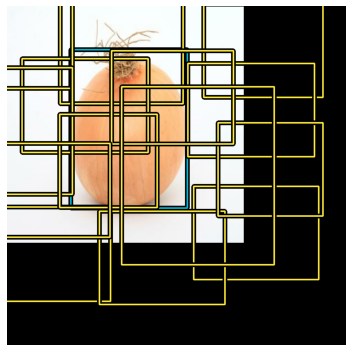

In [34]:
for result in test_data.take(1):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1]
    )

In [35]:
model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_677')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 38), dtype=tf.float32, name=None)]]
Captures:
  139695975897872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975893824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975901568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975898928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975899808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975906144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975760640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139695975761168: TensorSpec(shape=(), dtype=tf.r

In [50]:
print(model.outputs)

[<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_864>, <KerasTensor shape=(None, None, 38), dtype=float32, sparse=False, name=keras_tensor_865>]
